In [1]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [2]:
from scipy.io import loadmat, savemat
from scipy.linalg import orth
import numpy as np
import faiss
from scipy.spatial.distance import cdist
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
import gc

In [3]:
from lava.magma.core.process.process import AbstractProcess
from lava.magma.core.process.variable import Var
from lava.magma.core.process.ports.ports import InPort, OutPort

class Dense(AbstractProcess):
    """Dense connections between neurons.
    Realizes the following abstract behavior:
    a_out = W * s_in
    """

    def __init__(self, **kwargs):
        super().__init__()
        shape = kwargs.get("shape", (1, 1))
        self.s_in = InPort(shape=(shape[1],))
        self.a_out = OutPort(shape=(shape[0],))
        self.weights = Var(shape=shape, init=kwargs.pop("weights", 0))

import numpy as np

from lava.magma.core.sync.protocols.loihi_protocol import LoihiProtocol
from lava.magma.core.model.py.ports import PyInPort, PyOutPort
from lava.magma.core.model.py.type import LavaPyType
from lava.magma.core.resources import CPU
from lava.magma.core.decorator import implements, requires
from lava.magma.core.model.py.model import PyLoihiProcessModel
#from lava.proc.dense.process import Dense
        
@implements(proc=Dense, protocol=LoihiProtocol)
@requires(CPU)
class PyDenseModel(PyLoihiProcessModel):
    s_in: PyInPort = LavaPyType(PyInPort.VEC_DENSE, bool)
    a_out: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, float)
    weights: np.ndarray = LavaPyType(np.ndarray, float)

    def run_spk(self):
        s_in = self.s_in.recv()
        a_out = self.weights[:, s_in].sum(axis=1)
        self.a_out.send(a_out)   

from lava.magma.core.process.process import AbstractProcess
from lava.magma.core.process.variable import Var
from lava.magma.core.process.ports.ports import InPort, OutPort
        
class LIF(AbstractProcess):
    """Leaky-Integrate-and-Fire (LIF) neural Process.

    LIF dynamics abstracts to:
    u[t] = u[t-1] * (1-du) + a_in                              # neuron current
    v[t] = v[t-1] * (1-dv) + u[t] + bias_mant * 2 ** bias_exp  # neuron voltage
    s_out = v[t] > vth                                         # spike if threshold is exceeded
    v[t] = 0                                                   # reset at spike

    Parameters
    ----------
    du: Inverse of decay time-constant for current decay.
    dv: Inverse of decay time-constant for voltage decay.
    bias_mant: Mantissa part of neuron bias.
    bias_exp: Exponent part of neuron bias, if needed. Mostly for fixed point
              implementations. Unnecessary for floating point
              implementations. If specified, bias = bias_mant * 2**bias_exp.
    vth: Neuron threshold voltage, exceeding which, the neuron will spike.
    """
    def __init__(self, **kwargs):
        super().__init__()
        shape = kwargs.get("shape", (1,))
        du = kwargs.pop("du", 0)
        dv = kwargs.pop("dv", 0)
        bias_mant = kwargs.pop("bias_mant", 0)
        bias_exp = kwargs.pop("bias_exp", 0)
        vth = kwargs.pop("vth", 10)

        self.shape = shape
        self.a_in = InPort(shape=shape)
        self.s_out = OutPort(shape=shape)
        self.u = Var(shape=shape, init=0)
        self.v = Var(shape=shape, init=0)
        self.du = Var(shape=(1,), init=du)
        self.dv = Var(shape=(1,), init=dv)
        self.bias_mant = Var(shape=shape, init=bias_mant)
        self.bias_exp = Var(shape=shape, init=bias_exp)
        self.vth = Var(shape=(1,), init=vth)
        
import numpy as np
from lava.magma.core.sync.protocols.loihi_protocol import LoihiProtocol
from lava.magma.core.model.py.ports import PyInPort, PyOutPort
from lava.magma.core.model.py.type import LavaPyType
from lava.magma.core.resources import CPU
from lava.magma.core.decorator import implements, requires
from lava.magma.core.model.py.model import PyLoihiProcessModel
#from lava.proc.lif.process import LIF

@implements(proc=LIF, protocol=LoihiProtocol)
@requires(CPU)
class PyLifModel1(PyLoihiProcessModel):
    a_in: PyInPort = LavaPyType(PyInPort.VEC_DENSE, float)
    s_out: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, bool, precision=1)
    u: np.ndarray = LavaPyType(np.ndarray, float)
    v: np.ndarray = LavaPyType(np.ndarray, float)
    bias_mant: np.ndarray = LavaPyType(np.ndarray, float)
    bias_exp: np.ndarray = LavaPyType(np.ndarray, float)
    du: float = LavaPyType(float, float)
    dv: float = LavaPyType(float, float)
    vth: float = LavaPyType(float, float)

    def run_spk(self):
        a_in_data = self.a_in.recv()
        self.u[:] = self.u * (1 - self.du)
        self.u[:] += a_in_data
        bias = self.bias_mant * (2 ** self.bias_exp)
        self.v[:] = self.v * (1 - self.dv) + self.u + bias
        s_out = self.v >= self.vth
        self.v[s_out] = 0  # Reset voltage to 0
        self.s_out.send(s_out)

class DenseLayer(AbstractProcess):
    """Combines Dense and LIF Processes.
    """
    def __init__(self, **kwargs):
        super().__init__()
        shape = kwargs.get("shape", (1, 1))
        du = kwargs.pop("du", 0)
        dv = kwargs.pop("dv", 0)
        bias = kwargs.pop("bias", 0)
        bias_exp = kwargs.pop("bias_exp", 0)
        vth = kwargs.pop("vth", 10)
        weights = kwargs.pop("weights", 0)
        
        self.shape = Var(shape=(1,1), init=shape)
        self.s_in = InPort(shape=(shape[1],))
        #output of Dense synaptic connections is only used internally
        #self.a_out = OutPort(shape=(shape[0],))
        self.weights = Var(shape=shape, init=weights)
        #input to LIF population from Dense synaptic connections is only used internally
        #self.a_in = InPort(shape=(shape[0],))
        self.s_out = OutPort(shape=(shape[0],))
        self.u = Var(shape=(shape[0],), init=0)
        self.v = Var(shape=(shape[0],), init=0)
        self.bias = Var(shape=(shape[0],), init=bias)
        self.du = Var(shape=(1,), init=du)
        self.dv = Var(shape=(1,), init=dv)
        self.vth = Var(shape=(1,), init=vth)
        #self.spikes = Var(shape=(shape[0],), init=0)

import numpy as np

from lava.proc.lif.process import LIF
from lava.proc.dense.process import Dense
from lava.magma.core.model.sub.model import AbstractSubProcessModel

from lava.magma.core.sync.protocols.loihi_protocol import LoihiProtocol
from lava.magma.core.decorator import implements
        
@implements(proc=DenseLayer, protocol=LoihiProtocol)
class SubDenseLayerModel(AbstractSubProcessModel):

    def __init__(self, proc):
        """Builds sub Process structure of the Process."""
        # Instantiate child processes
        #input shape is a 2D vec (shape of weight mat)
#         shape = proc.init_args.get("shape",(1,1))
        shape = proc.shape.init
#         weights = proc.init_args.get("weights",(1,1))
        weights = proc.weights.init
#         bias = proc.init_args.get("bias",(1,1))
        bias = proc.bias.init
#         vth = proc.init_args.get("vth",(1,1))
        vth = proc.vth.init
            
        #shape is a 2D vec (shape of weight mat)
        self.dense = Dense(shape=shape, weights=weights)
        #shape is a 1D vec
        self.lif = LIF(shape=(shape[0],),bias_mant=bias,vth=vth)
        # connect Parent in port to child Dense in port
        proc.in_ports.s_in.connect(self.dense.in_ports.s_in)
        # connect Dense Proc out port to LIF Proc in port
        self.dense.out_ports.a_out.connect(self.lif.in_ports.a_in)
        # connect child LIF out port to parent out port
        self.lif.out_ports.s_out.connect(proc.out_ports.s_out)

        proc.vars.u.alias(self.lif.vars.u)
        proc.vars.v.alias(self.lif.vars.v)
        proc.vars.bias.alias(self.lif.vars.bias_mant)
        proc.vars.du.alias(self.lif.vars.du)
        proc.vars.dv.alias(self.lif.vars.dv)
        proc.vars.vth.alias(self.lif.vars.vth)
        proc.vars.weights.alias(self.dense.vars.weights)
        #proc.vars.spikes.alias(self.lif.vars.spikes)


from lava.magma.core.run_configs import RunConfig, Loihi1SimCfg
from lava.magma.core.run_conditions import RunSteps

def findMatch_Thimal(dbVectors, queryVector, timesteps, ks, verbose=False, showDotProduct=False):

    # Set the shape to the dbVectors shape
    dim_layer0=(queryVector.shape[0], queryVector.shape[0])
    dim_layer1=dbVectors.shape
    
    # These weights should not matter, set them to zeros
    #set targeted weight mat
    weights0 = np.zeros(shape=dim_layer0)
    
    # Valvulate the v_values using the query vector
    v_values = np.array([(-((1-i)*timesteps)+1) for i in queryVector])
    
    ones = np.ones((dim_layer0[0],))
    zeros = np.zeros((dim_layer1[0],))
    
    #instantiate 2 DenseLayers
    layer0 = DenseLayer(shape=dim_layer0, weights=weights0, dv=zeros, du=ones, bias=1, vth=1)
    layer1 = DenseLayer(shape=dim_layer1,weights=dbVectors, dv=zeros, du=ones, bias=0, vth=timesteps*10) # vth=timesteps so that second layer never spikes (if values in db are <1)
    
    #connect layer 0 to layer 1
    layer0.s_out.connect(layer1.s_in)

    if verbose:
        print('Layer 1 weights: \n', layer1.weights.get(),'\n')
        print('\n ----- \n')

    rcfg = Loihi1SimCfg(select_tag='floating_pt', select_sub_proc_model=True)


    # +1 since the first timestep is for encoding the v_values
    for t in range(timesteps+1):
        #running layer 1 runs all connected layers (layer 0)
        layer1.run(condition=RunSteps(num_steps=1),run_cfg=rcfg)

        # Insert the query vector on the first timestep
        if (t == 0):
            layer0.v.set(v_values)
        
        # print('t: ', t)

        if verbose:
            print('t: ',t)
            print('Layer 0 u: ', layer0.u.get())
            print('Layer 0 v: ', layer0.v.get())
            print('Layer 1 u: ', layer1.u.get())
            print('Layer 1 v: ', layer1.v.get())
            #print('Layer 1 spikes: ', layer1.spikes.get())
            print('\n ----- \n')

    # Save the index of the neuron with the highest activation
    #returnValue = np.argmax(layer1.u.get())
    
    # Divide by timesteps to get the approximated dot product
    aproxDotProduct = (layer1.u.get()/timesteps)
    
    if showDotProduct:
        print("SNN dot product: " + str(aproxDotProduct) + "\n")
    
#     returnValues = []
    
#     for k in ks:
#         returnValue = np.argsort(aproxDotProduct)[-k:]
#         returnValues.append(returnValue)
    
    # Stop the execution
    layer1.stop()
    
    # Return the index of the neuron with the highes activation
    #return returnValues
    return np.argsort(aproxDotProduct)[::-1][:100]

### New findMatch function

In [4]:
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi1SimCfg
import math

def findMatchMySNN(dbVectors, queryVector, timesteps = 1000, ks=0, verbose=False, showDotProduct=False):

    timesteps = 1000
    
    if queryVector.shape[0] != dbVectors.shape[1]:
        assert("Dims do not match!")

    n_vec = dbVectors.shape[0]
    dims  = dbVectors.shape[1]

    # scaling the query vector
    q_alt = [ (timesteps/2)*elem for elem in queryVector]
    init_v = [ -(timesteps - 2*elem - 1) for elem in q_alt]

    all_negative = True
    for val in init_v:
        if val < 0:
            all_negative = False
            break
    if all_negative == False:
        assert("Some encoded init voltages are negative")

    lif1   = LIF(shape=(dims,), bias_mant=1, vth=1, v=init_v)
    
    weights = np.array(dbVectors).reshape(n_vec,dims).astype(float)
    dense = Dense(weights=weights)
    
    lif2   = LIF(shape=(n_vec,), vth=math.inf, bias_mant=0)

    lif1.s_out.connect(dense.s_in)
    dense.a_out.connect(lif2.a_in)

    lif2.run(condition=RunSteps(num_steps=timesteps), run_cfg=Loihi1SimCfg())
    
    # Divide by scaling factor to get the approximated dot product
    aproxDotProduct = lif2.u.get()/(timesteps/2)

    # for i in range(len(aproxDotProduct)):
    #     print(f'dot prod {i} : {aproxDotProduct[i]}')
    
    lif2.stop()
    
    # Return the index of the neuron with the highes activation
    #return returnValues
    return np.argsort(aproxDotProduct)[::-1][:100]

## Real Dot Product

In [5]:
def findMatch(dbVectors, queryVector, timesteps = 1000, ks=0, verbose=False, showDotProduct=False):

    aproxDotProduct = []
    for i in range(len(dbVectors)):
        aproxDotProduct.append( np.dot(queryVector, dbVectors[i]) )
    
    return np.argsort(aproxDotProduct)[::-1][:100]

In [6]:
# function from plate library for HRR
def generate(size, norm=False,only_positive = False):
    """Generates normally distributed random vectors of size."""
    if isinstance(size, (int, float)):
        size = (size,)
    if len(size) == 1:
        size = (1, size[0])
    if only_positive:
        vecs = np.random.normal(0, size=size,
                                scale=1 / size[1]) # convert to positive check whether this is the correct way
        print(np.min(vecs))
        vecs = vecs + np.abs(np.min(vecs))
    else:
        vecs = np.random.normal(0, size=size, scale=1/size[1])
    if norm:
        vecs /= np.linalg.norm(vecs, axis=1)[:, None]
    return vecs


def addition(p):
    return np.sum(p, 0)


def circular_convolution(x, y):
    """A fast version of the circular convolution."""
    # Stolen from:
    # http://www.indiana.edu/~clcl/holoword/Site/__files/holoword.py
    z = np.fft.ifft(np.fft.fft(x) * np.fft.fft(y)).real
    if np.ndim(z) == 1:
        z = z[None, :]
    return z


def involution(x):
    """Involution operator."""
    if np.ndim(x) == 1:
        x = x[None, :]
    return np.concatenate([x[:, None, 0], x[:, -1:0:-1]], 1)


def circular_correlation(x, y):
    """Circular correlation is the inverse of circular convolution."""
    return circular_convolution(involution(x), y)


def decode(x, y):
    """Simple renaming."""
    return circular_correlation(x, y)

def matlab_normalize(A):
    # https://au.mathworks.com/help/matlab/ref/double.normalize.html
    # https://stackoverflow.com/questions/4544292/how-do-i-standardize-a-matrix/4544459
    A = (A - np.mean(A, axis=1).reshape(-1, 1)) / np.std(A, axis=1).reshape(-1, 1)
    return A

In [7]:
delf_mat_1 = loadmat("aggrigation_data/GardensPointWalking/day_left/delf.mat")
delf_mat_2 = loadmat("aggrigation_data/GardensPointWalking/night_right/delf.mat")

Yval = delf_mat_1["Y"]
Yval2 = delf_mat_2["Y"]

g_truth = loadmat("aggrigation_data/gt.mat")

print(f'delf_mat_1 : {delf_mat_1.keys()}')
print(f'delf_mat_2 : {delf_mat_2.keys()}')
print(f'g_truth   : {g_truth.keys()}')

# A_mat = loadmat("aggrigation_data/A.mat")
# X_mat = loadmat("aggrigation_data/X.mat")
# Y_mat = loadmat("aggrigation_data/Y.mat")

#setup parameters
params  ={}
params["nDims"]=4096;
params["nFeat"]=200; 
params["nX"]=4; 
params["nY"]=6; 
params["sDims"] = Yval[0]["descriptors"][0].shape[1]

delf_mat_1 : dict_keys(['__header__', '__version__', '__globals__', 'Y'])
delf_mat_2 : dict_keys(['__header__', '__version__', '__globals__', 'Y'])
g_truth   : dict_keys(['__header__', '__version__', '__globals__', 'GT'])


In [8]:
def sparsify(arr,k=1000):
    block_size = len(arr)//k
    for j in range(0, len(arr), block_size):
        if arr[j:].size>block_size:
            temp = np.zeros(block_size)
            temp[np.argmax(arr[j: j + block_size])] = 1
        else:
            temp = np.zeros(arr[j:].size)
            temp[np.argmax(arr[j: j + arr[j:].size])] = 1
        arr[j: j + block_size] = arr[j: j + block_size] * temp
    return arr


def sparsify_all(arr_list,k=1000):
    arr_s_list = np.zeros(arr_list.shape)
    for j in range(len(arr_list)):
        arr_s_list[j,:] = sparsify(arr_list[j],k)
    return arr_s_list


# def sparsify_random(arr,k):
#     for j in range(0, len(arr), 10):
#         if arr[j:].size>10:
#             temp = np.zeros(10)
#             temp[np.random.choice(10,1)] = 1
#         else:
#             temp = np.zeros(arr[j:].size)
#             temp[np.argmax(arr[j: j + arr[j:].size])] = 1
#         arr[j: j + 10] = arr[j: j + 10] * temp
#     return arr


def sparsify_random(arr,k=1000):
    block_size = len(arr)//k
    for j in range(0, len(arr), block_size):
        if arr[j:].size>block_size:
            temp = np.zeros(block_size)
            temp[np.random.choice(block_size,1)] = 1
        else:
            temp = np.zeros(arr[j:].size)
            temp[np.argmax(arr[j: j + arr[j:].size])] = 1
        arr[j: j + block_size] = arr[j: j + block_size] * temp
    return arr


def sparsify_all_random(arr_list,k=1000):
    arr_s_list = np.zeros(arr_list.shape)
    for j in range(len(arr_list)):
        arr_s_list[j,:] = sparsify_random(arr_list[j],k)
    return arr_s_list

In [9]:
def encodeImagesHDC(Y,params):
    
    nIm = Y.shape[0]   # 200 (number of images)
    hdcD = np.zeros((nIm, params["nDims"]))  # (200,4096)
    for i in range(nIm):  # for each image
        
#         % we use params.nFeat local feature descriptors D
        nFeat = min(params["nFeat"], Y[i]["descriptors"][0].shape[0])
        D = Y[i]["descriptors"][0]
        
#         % we need poses P to be in range [0,1]
        P = Y[i]["keypoints"][0]  / [Y[i]["imsize"][0][0][1], Y[i]["imsize"][0][0][0]]
        P[np.isnan(P)]=0;
        assert np.all(P>=0)
        
        hdcD[i,:] = bundleLocalDescriptorsWithPoses(D, P, params)
    return hdcD


# In[ ]:





# In[276]:


# % Bind each pre-processed descriptor to its pose encoding and bundle
# %
# % D ... descriptor matrix, each row is descriptor
# % P ... pose matrix, each row is pose [y,x]
# %
# % hdcD ... output descriptor, row vector of length params.nDims

def bundleLocalDescriptorsWithPoses(D, P, params):
    projD = np.matmul(D,A);

#     % standardize descriptors per image        
    mu = np.mean(projD,axis=0)
    sigma = np.std(projD,axis=0)
    stdProjD = np.divide(np.subtract(projD,mu),sigma)
    stdProjD[np.isnan(stdProjD)] = 0
    
#     %% encode poses
    encodedP = encodePosesHDCconcatMultiAttractor(P, params)

#     %% bind each descriptor to its pose and bundle
    if hrr_flag:
        hdcD = np.sum(circular_convolution(stdProjD, encodedP), axis=0)
    else:
        hdcD = np.sum(np.multiply(stdProjD,encodedP), axis=0)
    return hdcD


# In[277]:


# % Encode a 2d pose in a {-1,1} vector using the binding of an x and y
# % vector obtained from concatenating start and end base vectors for each
# % dimension.
# %
# % P ... pose matrix, each row is [y,x], each in [0,1]
# % 
# % encodedP ... each row is {-1,1} encoded pose
# % 
def encodePosesHDCconcatMultiAttractor(P, params):

#     %% prepare basis vectors
    nBaseX = params["nX"]+1
    posX = np.append(np.arange(0, 1,1/(nBaseX-1)),1)
        
    nBaseY = params["nY"]+1
    posY = np.append(np.arange(0, 1, 1/(nBaseY-1)),1)
    
#     %% check relative poses
    xr = P[:,1]
    yr = P[:,0]       
    assert np.all(xr>=0) and np.all(xr<=1)
    assert np.all(yr>=0) and np.all(yr<=1)
        
#     %% encode
    encodedP = np.zeros((P.shape[0], params["nDims"]))
    for i in range(P.shape[0]):
    
#         % find attractors and split index
        Yidx1, Yidx2, YsplitIdx =  findAttractorsAndSplitIdx(yr[i], posY, params["nDims"])
        Xidx1, Xidx2, XsplitIdx =  findAttractorsAndSplitIdx(xr[i], posX, params["nDims"])
        
#         % apply
        xVec = np.concatenate([X[Xidx1, :XsplitIdx],X[Xidx2, XsplitIdx:]])
        yVec = np.concatenate([Y[Yidx1, :YsplitIdx],Y[Yidx2, YsplitIdx:]])
        
#         % combine
        if hrr_flag:
            encodedP[i, :] = circular_convolution(xVec, yVec)
        else:
            encodedP[i,:] = np.multiply(xVec, yVec)
    return encodedP


# In[278]:


# % Find the indices of the neighboring base vectors and the split index for
# % the concatenation
# %
# % p ... input pos, in [0,1]
# % attractorP ... vector with a postion value 0...1 for each attractor
# % nDIms ... number of dimensions
# %
# % idx1, idx2 ... indices of base vectors
# % splitIdx ... index, where to split the base vectors
# %
def findAttractorsAndSplitIdx(p, attractorP, nDims):

    assert p>=0 ;
    assert p<=1;
    assert not np.any(attractorP[:]<0) ;
    assert not np.any(attractorP[:]>1);

#     % find x attractor below (the largest pos that is smaller than p)
    idx1 = max(np.argwhere(attractorP<=p))[0];
        
#     % find x attractor above (the smallest pos that is larger than p)
    idx2 = min(np.argwhere(attractorP>=p))[0];
        
#     % find weighting
    d1 = abs(attractorP[idx1]-p);
    d2 = abs(attractorP[idx2]-p);
    w = d2/(d1+d2); 
    
    if np.isnan(w):
        w = 0;
    
#     % compute index from weighting 
    splitIdx = round(w*nDims);
    return idx1, idx2, splitIdx
    



# In[354]:


# % Compute precision and recall vectors for a given similarrity matrix
# % and binary ground truth matrices. 
# %
# % S ... similarity matrix
# % GThard ... ground truth matching matrix: 1 at places that must be matched,
# %            else 0; must have the same shape as S
# % GTsoft ... ground truth places that CAN be matched without penalty; must
# %            have the same shape as S
# %
# % P ... precision vector
# % R ... recall vector
def createPR(S, GThard, GTsoft):
    
    #% remove soft-but-not-hard-entries
    S[np.where(GTsoft &  ~GThard)] = np.min(S[:]);

    
    GT = GThard #; % ensure logical-datatype
    
#     % init precision and recall vectors
    R = [];
    P = [];
    
#     % select start and end treshold
    startV = np.max(S[:]); #% start-value for treshold
    endV = np.min(S[:]); #% end-value for treshold
    
#     % iterate over different thresholds
    for i in np.linspace(startV, endV, 100):
        B = S>=i; #% apply threshold
        
        TP = np.count_nonzero( GT & B ); #% true positives
        FN = np.count_nonzero( GT & (~ B) ); #% false negatives
        FP = np.count_nonzero( (~ GT) & B ); #% false positives
        
        P.append(TP/(TP + FP)); #% precision
        R.append(TP/(TP + FN)); #% recall
    return R,P



def getRecallAtN(n_values, predictions, gt):
    correct_at_n = np.zeros(len(n_values))
    numQWithoutGt = 0
    #TODO can we do this on the matrix in one go?
    for qIx, pred in enumerate(predictions):
        # if len(gt[qIx]) == 0:
        #     numQWithoutGt += 1
        #     continue
        for i,n in enumerate(n_values):
            # if in top N then also in top NN, where NN > N
            if np.any(np.in1d(pred[:n], gt[qIx])):
                correct_at_n[i:] += 1
                break
    return correct_at_n / (len(gt)-numQWithoutGt)

def recall(D1,D2, GThard):
    n_values = [1,5,10,20,100]
    D1 = D1.astype(np.float32)
    D2 = D2.astype(np.float32)
    faiss_index = faiss.index_factory(D1.shape[1], "Flat", faiss.METRIC_INNER_PRODUCT)
    faiss.normalize_L2(D1)
    faiss_index.add(D1)

    faiss.normalize_L2(D2)
    distances, predictions = faiss_index.search(D2, max(n_values))
    # faiss_index = faiss.IndexFlatL2(D1.shape[1])
    # faiss_index.add(D1)

    distances, predictions = faiss_index.search(D2, max(n_values))
    gt = GThard.nonzero()[1]
    recall_at_n = getRecallAtN(n_values, predictions, gt)

    recalls = {}  # make dict for output
    for i, n in enumerate(n_values):
        recalls[n] = recall_at_n[i]
        print("====> Recall@{}: {:.4f}".format(n, recall_at_n[i]))


def directCandSel(DD, n=100):

    nDB, nQ = DD.shape


    Idx = np.zeros((n, nQ))

    for j in range(nQ):
        idx = np.argsort(DD[:, j]);
        Idx[:, j] = idx[:n];
    return Idx



def getRecallAtKVector(Idx, GT):

    k, nQ = Idx.shape

    r = np.zeros(k);
    nMustFind = 0;
    for j in range(nQ):

    #only evaluate if there is a GThard matching for this query
        if np.any(GT["GThard"][0][0][: ,j]):

            nMustFind = nMustFind + 1;

            for i in range(k):
                # if np.any(GT["GTsoft"][0][0][Idx[:i+1, j], j] == 1):
                if np.any(np.take(GT["GTsoft"][0][0][:, j], Idx[:i + 1, j].astype(int))==1):
                    r[i] = r[i] + 1;

    r = r / nMustFind;
    return r

## Get the R_BIPOLAR Original Delf Descriptor

In [10]:
# Bipolar CPU 
#main
# encode query and database to HD vectors

hrr_flag = False
recal_val_label = "only_positive_HRR"
only_positive = False

np.random.seed(np.sum(np.frombuffer(b'projection', dtype=np.uint8)))
#A = np.random.random((params["sDims"],params["nDims"]))
#A = np.random.normal(0, 0.1, (params["sDims"],params["nDims"]))
if only_positive:
    A = np.random.randn(params["sDims"], params["nDims"])
    print(np.min(A))
    vecs = A +np.abs(np.min(A))
else:
    A = np.random.randn(params["sDims"], params["nDims"])
#A = orth(A.T).T
# load matlab file
#A = A_mat["A"]

nBaseX = params["nX"]+1;
np.random.seed(np.sum(np.frombuffer(b'poseX', dtype=np.uint8)))
X = 1-2*(np.random.random((nBaseX, params["nDims"]))>0.5);
#X =  generate((nBaseX, params["nDims"]),only_positive=only_positive)
#X = X_mat["X"]

nBaseY = params["nY"]+1;
np.random.seed(np.sum(np.frombuffer(b'poseY', dtype=np.uint8)))
Y = 1-2*(np.random.random((nBaseY, params["nDims"]))>0.5);
#Y = generate((nBaseY, params["nDims"]),only_positive=only_positive)
#Y = Y_mat["Y"]


D1 = encodeImagesHDC(Yval, params)
D2 = encodeImagesHDC(Yval2, params)


/tmp/ipykernel_1573154/182283052.py:131: RuntimeWarning: invalid value encountered in double_scalars
  w = d2/(d1+d2);


In [11]:
# print(D1.shape)
# tt = np.mean(D1,axis=0)
# print(tt.shape)
# sub = np.subtract(D1,mu1)
# print(sub.shape)
# arr = np.array([[1,1],[2,2]])
# tt = np.mean(arr,axis=0)
# print(tt)

In [12]:
ff = np.array( [[1,2,3],[4,5,6],[7,8,9]] )
# print(directCandSel(ff))
print(np.argsort(ff[:, 0]))

[0 1 2]


In [13]:
# Calculate the distance matrix

mu1 = np.mean(D1,axis=0)

DD = cdist(np.subtract(D1,mu1), np.subtract(D2,mu1), 'cosine')


# select candidates k indices
ids = directCandSel(DD)
# calculate recall values
r_bipolar =getRecallAtKVector(ids,g_truth["GT"])
print(r_bipolar)

# df =pd.read_csv("aggregate_code_git/loihi_knn_SLAM/HD_aggregation_src/python/recall_values_GPW.csv")
# df[recal_val_label] = r
# df.to_csv("aggregate_code_git/loihi_knn_SLAM/HD_aggregation_src/python/recall_values_GPW.csv")

recall_values = loadmat("HDC-DELF-data/recall_at_k.mat")
#original recall values
print(recall_values["recall_at_k_per_experiment"][3])

[0.84  0.875 0.905 0.92  0.935 0.95  0.955 0.965 0.98  0.99  0.99  0.995
 0.995 0.995 0.995 1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.   ]
[0.97655068 0.98108926 0.98411498 0.98562784 0.9871407  0.98865356
 0.98940998 0.98940998 0.98940998 0.99167927 0.99167927 0.9924357
 0.9924357  0.9924357  0.99319213 0.99319213 0.99319213 0.99319213
 0.99319213 0.99319213 0.99394856 0.99394856 0.99470499 0.99470499
 0.99470499 0.99470499 0.99470499 0.99470499 0.99470499 0.99470499
 0.99470499 0.99470499 0.99546142 0.99546142 0.99546142 0.99546142
 0.9954614

In [14]:
recall_values = loadmat("HDC-DELF-data/recall_at_k.mat")
#original recall values
print(recall_values["recall_at_k_per_experiment"][0])

[0.98  0.995 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.   ]


In [15]:

recall_values["recall_at_k_per_experiment"][22]

array([0.971549  , 0.98419389, 0.98630137, 0.98946259, 0.99262381,
       0.99262381, 0.99367756, 0.9947313 , 0.99578504, 0.99683878,
       0.99789252, 0.99789252, 0.99789252, 0.99789252, 0.99894626,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [16]:
#HRR CPU
#main
# encode query and database to HD vectors

hrr_flag = True
recal_val_label = "only_positive_HRR"
only_positive = False

np.random.seed(np.sum(np.frombuffer(b'projection', dtype=np.uint8)))
#A = np.random.random((params["sDims"],params["nDims"]))
#A = np.random.normal(0, 0.1, (params["sDims"],params["nDims"]))
if only_positive:
    A = np.random.randn(params["sDims"], params["nDims"])
    print(np.min(A))
    vecs = A +np.abs(np.min(A))
else:
    A = np.random.randn(params["sDims"], params["nDims"])
#A = orth(A.T).T
# load matlab file
#A = A_mat["A"]

nBaseX = params["nX"]+1;
np.random.seed(np.sum(np.frombuffer(b'poseX', dtype=np.uint8)))
#X = 1-2*(np.random.random((nBaseX, params["nDims"]))>0.5);
X =  generate((nBaseX, params["nDims"]),only_positive=only_positive)
#X = X_mat["X"]

nBaseY = params["nY"]+1;
np.random.seed(np.sum(np.frombuffer(b'poseY', dtype=np.uint8)))
#Y = 1-2*(np.random.random((nBaseY, params["nDims"]))>0.5);
Y = generate((nBaseY, params["nDims"]),only_positive=only_positive)
#Y = Y_mat["Y"]


D1 = encodeImagesHDC(Yval, params)
D2 = encodeImagesHDC(Yval2, params)

/tmp/ipykernel_1573154/182283052.py:131: RuntimeWarning: invalid value encountered in double_scalars
  w = d2/(d1+d2);


In [17]:
# Calculate the distance matrix

mu1 = np.mean(D1,axis=0)

DD = cdist(np.subtract(D1,mu1), np.subtract(D2,mu1), 'cosine')


# select candidates k indices
ids = directCandSel(DD)
# calculate recall values
r_HRR =getRecallAtKVector(ids,g_truth["GT"])
print(r_HRR)

# df =pd.read_csv("aggregate_code_git/loihi_knn_SLAM/HD_aggregation_src/python/recall_values_GPW.csv")
# df[recal_val_label] = r
# df.to_csv("aggregate_code_git/loihi_knn_SLAM/HD_aggregation_src/python/recall_values_GPW.csv")

recall_values = loadmat("HDC-DELF-data/recall_at_k.mat")
#original recall values
print(recall_values["recall_at_k_per_experiment"][2])

[0.865 0.915 0.935 0.95  0.965 0.97  0.97  0.97  0.98  0.985 0.985 0.99
 0.99  0.99  0.995 1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.   ]
[0.84  0.88  0.93  0.945 0.95  0.96  0.965 0.97  0.975 0.98  0.98  0.98
 0.985 0.985 0.985 0.99  0.99  0.99  0.99  0.99  0.99  0.99  0.995 1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.   

In [18]:
r_bipolar

array([0.84 , 0.875, 0.905, 0.92 , 0.935, 0.95 , 0.955, 0.965, 0.98 ,
       0.99 , 0.99 , 0.995, 0.995, 0.995, 0.995, 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   ])

In [19]:
#HRR LOIHI
#main
# encode query and database to HD vectors

ks = [1, 3, 6, 9, 25, 50, 100]
timesteps = 100 # 200
hrr_flag = True
recal_val_label = "only_positive_HRR"
only_positive = False

np.random.seed(np.sum(np.frombuffer(b'projection', dtype=np.uint8)))
#A = np.random.random((params["sDims"],params["nDims"]))
#A = np.random.normal(0, 0.1, (params["sDims"],params["nDims"]))
if only_positive:
    A = np.random.randn(params["sDims"], params["nDims"])
    print(np.min(A))
    vecs = A +np.abs(np.min(A))
else:
    A = np.random.randn(params["sDims"], params["nDims"])
#A = orth(A.T).T
# load matlab file
#A = A_mat["A"]

nBaseX = params["nX"]+1;
np.random.seed(np.sum(np.frombuffer(b'poseX', dtype=np.uint8)))
#X = 1-2*(np.random.random((nBaseX, params["nDims"]))>0.5);
X =  generate((nBaseX, params["nDims"]),only_positive=only_positive)
#X = X_mat["X"]

nBaseY = params["nY"]+1;
np.random.seed(np.sum(np.frombuffer(b'poseY', dtype=np.uint8)))
#Y = 1-2*(np.random.random((nBaseY, params["nDims"]))>0.5);
Y = generate((nBaseY, params["nDims"]),only_positive=only_positive)
#Y = Y_mat["Y"]
D1 = encodeImagesHDC(Yval, params)
D2 = encodeImagesHDC(Yval2, params)
normalizer = Normalizer()
D1_norm = normalizer.fit_transform(D1)
D2_norm = normalizer.fit_transform(D2)

/tmp/ipykernel_1573154/182283052.py:131: RuntimeWarning: invalid value encountered in double_scalars
  w = d2/(d1+d2);


In [20]:
# D2_norm.shape
# tmp_v = [-1, 1, -1, 0, 10]
# np.sign(tmp_v)
# np.tile(np.sign(tmp_v), (len(D1_norm),1))

In [21]:
for index, vector in enumerate(tqdm(D2_norm)):
    print(index, vector.shape)
    query_sign_vec = np.tile(np.sign(vector), (len(D1_norm),1))
    print(query_sign_vec.shape)
    
    if (index == 0): break

  0%|          | 0/200 [00:00<?, ?it/s]

0 (4096,)
(200, 4096)


In [22]:
# send sign with datasetvectors
ks=0

maxK = 100
nQ = len(D2_norm)


print(maxK,nQ)

ids = np.zeros((maxK,nQ))
# Iterate through all vectors in queries
for index, vector in enumerate(tqdm(D2_norm)):
    #print("data point",index)
    query_sign_vec = np.tile(np.sign(vector), (len(D1_norm),1))
    # Let the snn produce a index
    #predictedIndexesPerK = bestDotMatch(np.multiply(D1_norm,query_sign_vec),np.abs(vector),ks)
    predictedIndexesPerK = findMatch(np.multiply(D1_norm,query_sign_vec),np.abs(vector), timesteps, ks)
    ids[:,index] = predictedIndexesPerK
    # calculate recall values
r_HRR_LOIHI =getRecallAtKVector(ids,g_truth["GT"])
print(r_HRR_LOIHI)

100 200


100%|██████████| 200/200 [00:00<00:00, 603.96it/s]


[0.835 0.9   0.915 0.925 0.94  0.945 0.95  0.955 0.97  0.975 0.975 0.975
 0.975 0.975 0.98  0.985 0.985 0.985 0.995 0.995 0.995 1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.   ]


In [23]:
r_bipolar

array([0.84 , 0.875, 0.905, 0.92 , 0.935, 0.95 , 0.955, 0.965, 0.98 ,
       0.99 , 0.99 , 0.995, 0.995, 0.995, 0.995, 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   ])

In [24]:
#HRR LOIHI
#main
# encode query and database to HD vectors

ks = [1, 3, 6, 9, 25, 50, 100]
timesteps = 500
hrr_flag = True
recal_val_label = "only_positive_HRR"
only_positive = False

np.random.seed(np.sum(np.frombuffer(b'projection', dtype=np.uint8)))
#A = np.random.random((params["sDims"],params["nDims"]))
#A = np.random.normal(0, 0.1, (params["sDims"],params["nDims"]))
if only_positive:
    A = np.random.randn(params["sDims"], params["nDims"])
    print(np.min(A))
    vecs = A +np.abs(np.min(A))
else:
    A = np.random.randn(params["sDims"], params["nDims"])
#A = orth(A.T).T
# load matlab file
#A = A_mat["A"]

nBaseX = params["nX"]+1;
np.random.seed(np.sum(np.frombuffer(b'poseX', dtype=np.uint8)))
#X = 1-2*(np.random.random((nBaseX, params["nDims"]))>0.5);
X =  generate((nBaseX, params["nDims"]),only_positive=only_positive)
#X = X_mat["X"]

nBaseY = params["nY"]+1;
np.random.seed(np.sum(np.frombuffer(b'poseY', dtype=np.uint8)))
#Y = 1-2*(np.random.random((nBaseY, params["nDims"]))>0.5);
Y = generate((nBaseY, params["nDims"]),only_positive=only_positive)
#Y = Y_mat["Y"]
D1 = encodeImagesHDC(Yval, params)
D2 = encodeImagesHDC(Yval2, params)
normalizer = Normalizer()
D1_norm = normalizer.fit_transform(D1)
D2_norm = normalizer.fit_transform(D2)

# send sign with datasetvectors
ks=0

maxK = 100
nQ = len(D2_norm)


print(maxK,nQ)

ids = np.zeros((maxK,nQ))
# Iterate through all vectors in queries
for index, vector in enumerate(tqdm(D2_norm)):
    #print("data point",index)
    query_sign_vec = np.tile(np.sign(vector), (len(D1_norm),1))
    # Let the snn produce a index
    #predictedIndexesPerK = bestDotMatch(np.multiply(D1_norm,query_sign_vec),np.abs(vector),ks)
    predictedIndexesPerK = findMatch(np.multiply(D1_norm,query_sign_vec),np.abs(vector), timesteps, ks)
    ids[:,index] = predictedIndexesPerK
    # calculate recall values
r_HRR_LOIHI_500 =getRecallAtKVector(ids,g_truth["GT"])
print(r_HRR_LOIHI_500)

/tmp/ipykernel_1573154/182283052.py:131: RuntimeWarning: invalid value encountered in double_scalars
  w = d2/(d1+d2);


100 200


100%|██████████| 200/200 [00:00<00:00, 604.67it/s]


[0.835 0.9   0.915 0.925 0.94  0.945 0.95  0.955 0.97  0.975 0.975 0.975
 0.975 0.975 0.98  0.985 0.985 0.985 0.995 0.995 0.995 1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.   ]


In [25]:
r_bipolar

array([0.84 , 0.875, 0.905, 0.92 , 0.935, 0.95 , 0.955, 0.965, 0.98 ,
       0.99 , 0.99 , 0.995, 0.995, 0.995, 0.995, 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   ])

In [26]:
df_r = pd.DataFrame(r_bipolar,columns=["original (CPU BIPOLAR)"])


In [27]:
df_r["CPU HRR"] = r_HRR
df_r["lava_step_100"] = r_HRR_LOIHI
df_r["lava_step_500"] = r_HRR_LOIHI_500

In [28]:
df_r.T.iloc[:,0:20]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
original (CPU BIPOLAR),0.840,0.875,0.905,0.920,0.935,0.950,0.955,0.965,0.98,0.990,0.990,0.995,0.995,0.995,0.995,1.000,1.000,1.000,1.000,1.000
CPU HRR,0.865,0.915,0.935,0.950,0.965,0.970,0.970,0.970,0.98,0.985,0.985,0.990,0.990,0.990,0.995,1.000,1.000,1.000,1.000,1.000
lava_step_100,0.835,0.900,0.915,0.925,0.940,0.945,0.950,0.955,0.97,0.975,0.975,0.975,0.975,0.975,0.980,0.985,0.985,0.985,0.995,0.995
lava_step_500,0.835,0.900,0.915,0.925,0.940,0.945,0.950,0.955,0.97,0.975,0.975,0.975,0.975,0.975,0.980,0.985,0.985,0.985,0.995,0.995


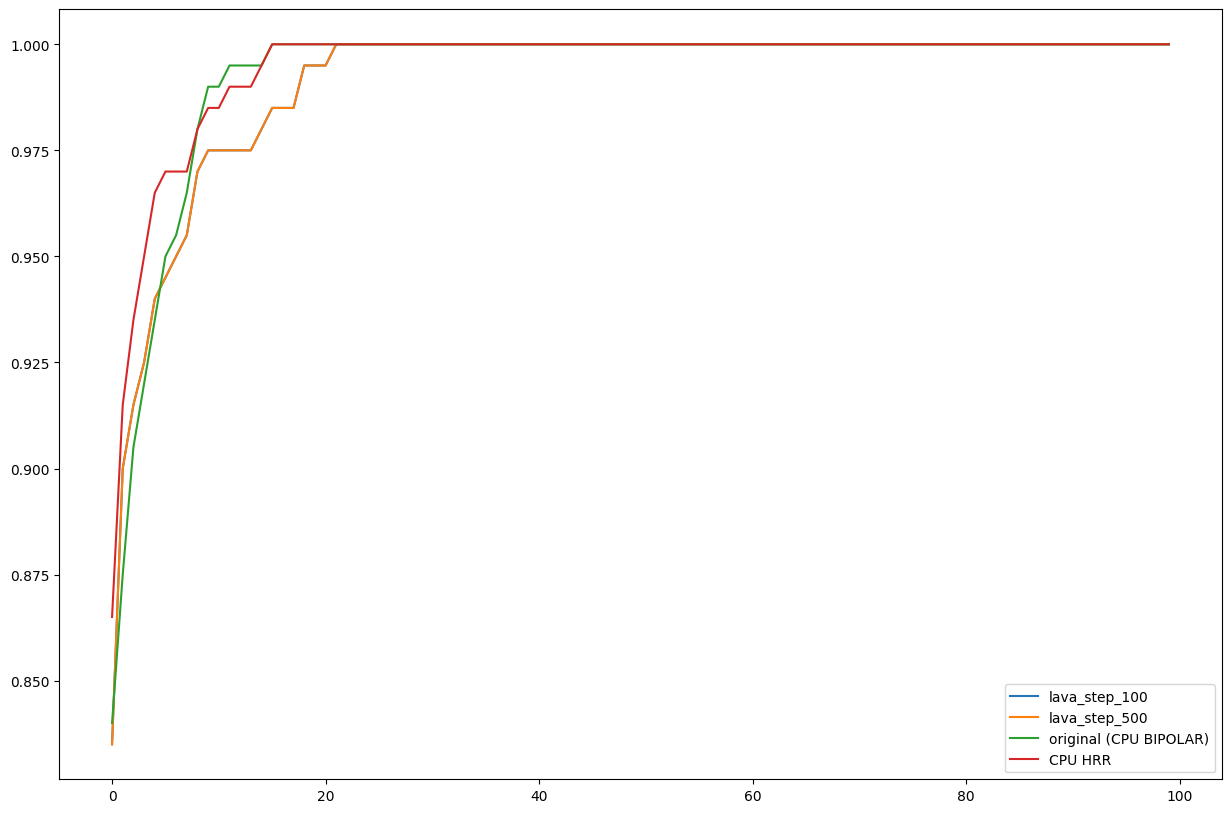

In [29]:
plt.figure(figsize=(15,10))
plt.plot(r_HRR_LOIHI,label="lava_step_100")
plt.plot(r_HRR_LOIHI_500,label="lava_step_500")
plt.plot(r_bipolar,label="original (CPU BIPOLAR)")
plt.plot(r_HRR,label="CPU HRR")

plt.legend()

In [30]:
#HRR LOIHI
#main
# encode query and database to HD vectors

ks = [1, 3, 6, 9, 25, 50, 100]
timesteps = 2000
hrr_flag = True
recal_val_label = "only_positive_HRR"
only_positive = False

np.random.seed(np.sum(np.frombuffer(b'projection', dtype=np.uint8)))
#A = np.random.random((params["sDims"],params["nDims"]))
#A = np.random.normal(0, 0.1, (params["sDims"],params["nDims"]))
if only_positive:
    A = np.random.randn(params["sDims"], params["nDims"])
    print(np.min(A))
    vecs = A +np.abs(np.min(A))
else:
    A = np.random.randn(params["sDims"], params["nDims"])
#A = orth(A.T).T
# load matlab file
#A = A_mat["A"]

nBaseX = params["nX"]+1;
np.random.seed(np.sum(np.frombuffer(b'poseX', dtype=np.uint8)))
#X = 1-2*(np.random.random((nBaseX, params["nDims"]))>0.5);
X =  generate((nBaseX, params["nDims"]),only_positive=only_positive)
#X = X_mat["X"]

nBaseY = params["nY"]+1;
np.random.seed(np.sum(np.frombuffer(b'poseY', dtype=np.uint8)))
#Y = 1-2*(np.random.random((nBaseY, params["nDims"]))>0.5);
Y = generate((nBaseY, params["nDims"]),only_positive=only_positive)
#Y = Y_mat["Y"]
D1 = encodeImagesHDC(Yval, params)
D2 = encodeImagesHDC(Yval2, params)
normalizer = Normalizer()
D1_norm = normalizer.fit_transform(D1)
D2_norm = normalizer.fit_transform(D2)

# send sign with datasetvectors
ks=0

maxK = 100
nQ = len(D2_norm)


print(maxK,nQ)

ids = np.zeros((maxK,nQ))
# Iterate through all vectors in queries
for index, vector in enumerate(tqdm(D2_norm)):
    #print("data point",index)
    query_sign_vec = np.tile(np.sign(vector), (len(D1_norm),1))
    # Let the snn produce a index
    #predictedIndexesPerK = bestDotMatch(np.multiply(D1_norm,query_sign_vec),np.abs(vector),ks)
    predictedIndexesPerK = findMatch(np.multiply(D1_norm,query_sign_vec),np.abs(vector), timesteps, ks)
    ids[:,index] = predictedIndexesPerK
    # calculate recall values
r_HRR_LOIHI_2000 =getRecallAtKVector(ids,g_truth["GT"])
print(r_HRR_LOIHI_2000)

/tmp/ipykernel_1573154/182283052.py:131: RuntimeWarning: invalid value encountered in double_scalars
  w = d2/(d1+d2);


100 200


100%|██████████| 200/200 [00:00<00:00, 600.70it/s]


[0.835 0.9   0.915 0.925 0.94  0.945 0.95  0.955 0.97  0.975 0.975 0.975
 0.975 0.975 0.98  0.985 0.985 0.985 0.995 0.995 0.995 1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.   ]


In [31]:
lava_s_500 = np.fromstring("0.835 0.9   0.935 0.935 0.94  0.95  0.96  0.96  0.965 0.97  0.975 0.975 0.975 0.98  0.98  0.98  0.98  0.98  0.98  0.985 0.985 0.99  0.995 0.995 0.995 0.995 1.    1.    1.    1.    1.    1.    1.    1.    1.    1. 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1. 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1. 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1. 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1. 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1. 1.    1.    1.    1.",sep = " ")

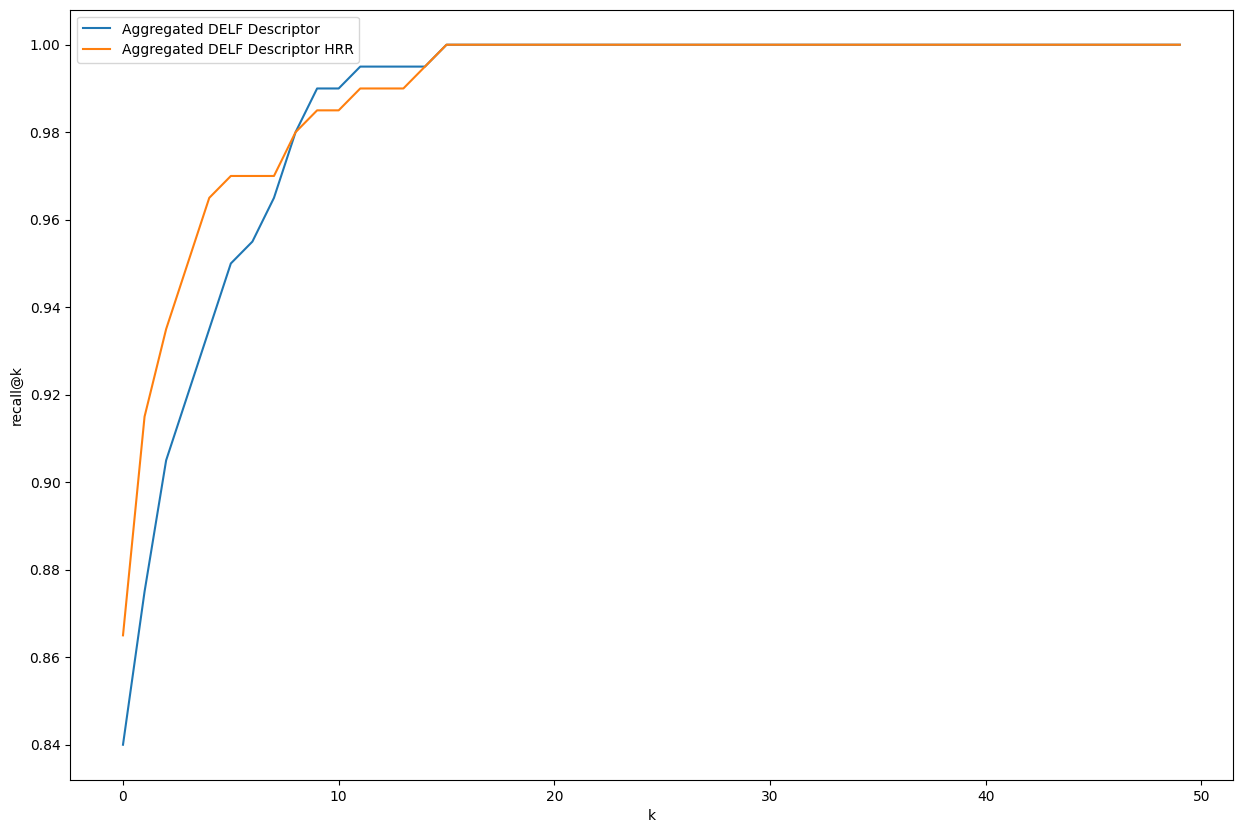

In [32]:
plt.figure(figsize=(15,10))
vals = 50
#plt.plot(lava_s_500[0:vals],label="lava_step_500(BIPOLAR)")
# plt.plot(r_HRR_LOIHI[0:vals],label="lava_step_100")
# plt.plot(r_HRR_LOIHI_500[0:vals],label="lava_step_500")
# plt.plot(r_HRR_LOIHI_2000[0:vals],label="lava_step_2000")
plt.plot(r_bipolar[0:vals],label="Aggregated DELF Descriptor")
plt.plot(r_HRR[0:vals],label="Aggregated DELF Descriptor HRR")

plt.xlabel("k")
plt.ylabel("recall@k")


plt.legend()
plt.savefig("output/HRR.pdf")

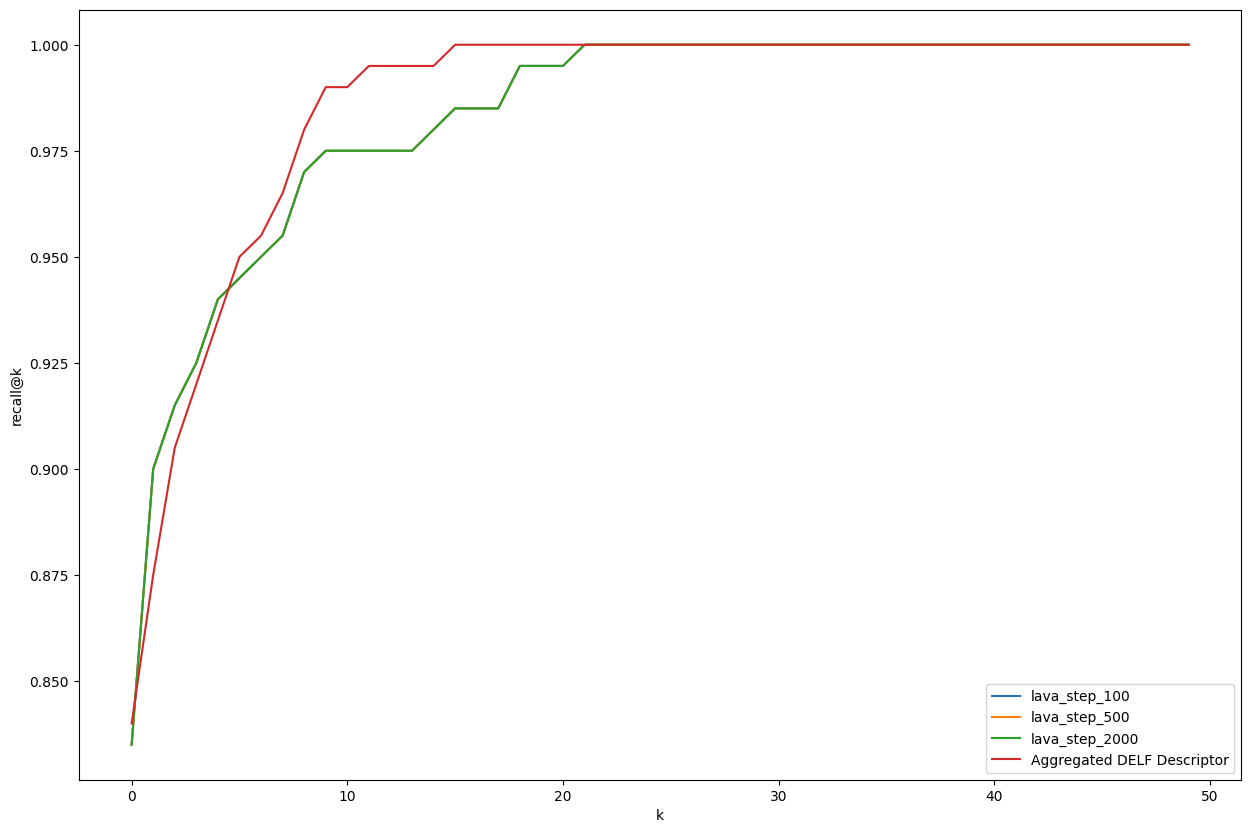

In [33]:
plt.figure(figsize=(15,10))
vals = 50
#plt.plot(lava_s_500[0:vals],label="lava_step_500(BIPOLAR)")
plt.plot(r_HRR_LOIHI[0:vals],label="lava_step_100")
plt.plot(r_HRR_LOIHI_500[0:vals],label="lava_step_500")
plt.plot(r_HRR_LOIHI_2000[0:vals],label="lava_step_2000")
plt.plot(r_bipolar[0:vals],label="Aggregated DELF Descriptor")
#plt.plot(r_HRR[0:vals],label="CPU HRR")


plt.xlabel("k")
plt.ylabel("recall@k")

plt.legend()
plt.savefig("output/lava_implementation.pdf")

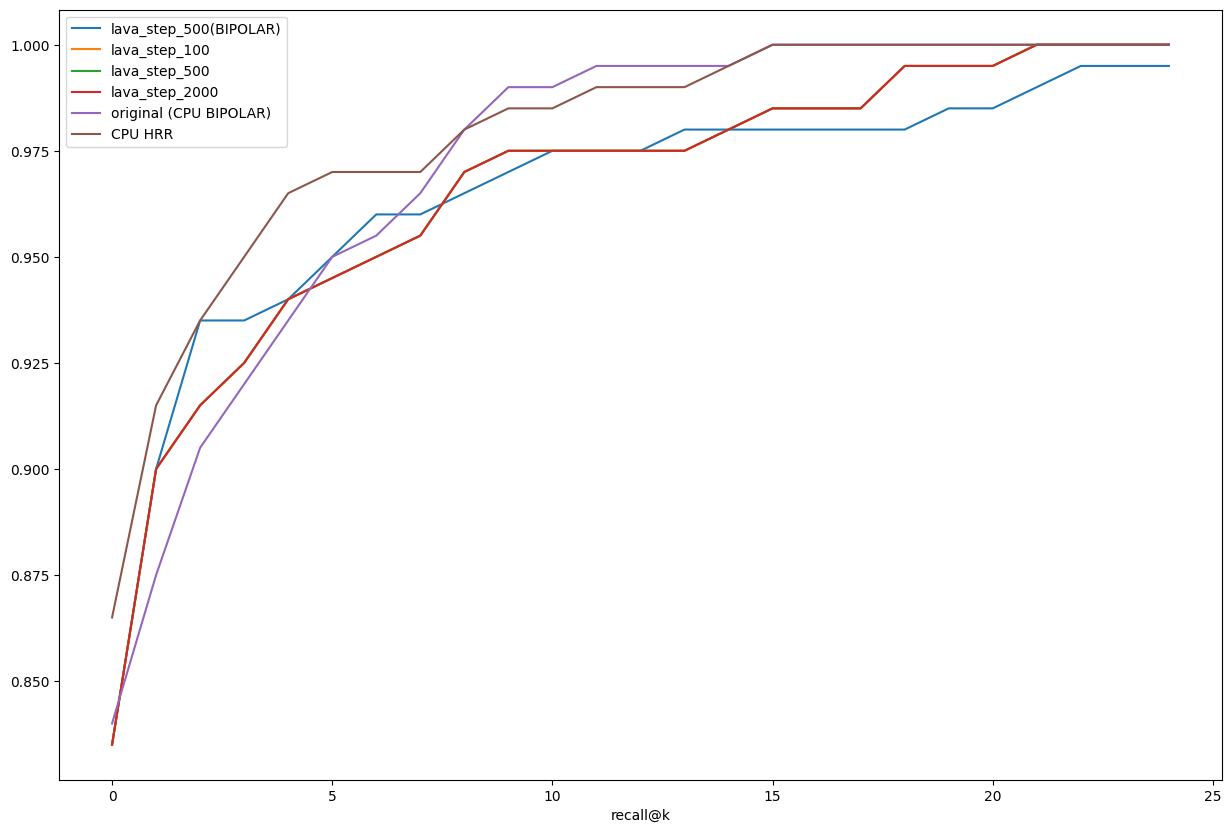

In [34]:
plt.figure(figsize=(15,10))
vals = 25
plt.plot(lava_s_500[0:vals],label="lava_step_500(BIPOLAR)")
plt.plot(r_HRR_LOIHI[0:vals],label="lava_step_100")
plt.plot(r_HRR_LOIHI_500[0:vals],label="lava_step_500")
plt.plot(r_HRR_LOIHI_2000[0:vals],label="lava_step_2000")
plt.plot(r_bipolar[0:vals],label="original (CPU BIPOLAR)")
plt.plot(r_HRR[0:vals],label="CPU HRR")

plt.xlabel("k")
plt.xlabel("recall@k")


plt.legend()

In [35]:
df_r["lava_step_2000"] = r_HRR_LOIHI_2000

In [36]:
df_r.T.iloc[:,0:20]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
original (CPU BIPOLAR),0.840,0.875,0.905,0.920,0.935,0.950,0.955,0.965,0.98,0.990,0.990,0.995,0.995,0.995,0.995,1.000,1.000,1.000,1.000,1.000
CPU HRR,0.865,0.915,0.935,0.950,0.965,0.970,0.970,0.970,0.98,0.985,0.985,0.990,0.990,0.990,0.995,1.000,1.000,1.000,1.000,1.000
lava_step_100,0.835,0.900,0.915,0.925,0.940,0.945,0.950,0.955,0.97,0.975,0.975,0.975,0.975,0.975,0.980,0.985,0.985,0.985,0.995,0.995
lava_step_500,0.835,0.900,0.915,0.925,0.940,0.945,0.950,0.955,0.97,0.975,0.975,0.975,0.975,0.975,0.980,0.985,0.985,0.985,0.995,0.995
lava_step_2000,0.835,0.900,0.915,0.925,0.940,0.945,0.950,0.955,0.97,0.975,0.975,0.975,0.975,0.975,0.980,0.985,0.985,0.985,0.995,0.995


In [37]:
def crvec(N, D=1):
    rphase = 2*np.pi * np.random.rand(int(D), int(N))
    return np.cos(rphase) + 1.0j * np.sin(rphase)

def scvec(N, D, K):
    letter_vectors_c = crvec(N, D)
    for d in range(D):
        ip = np.random.choice(int(N), size=int(N-K), replace=False)
        letter_vectors_c[d, ip] = 0
        
    return letter_vectors_c

def lccvec(N, D, K):
    R = N/K
    assert(R==N//K) # N needs to be multiple of K
    
    letter_vectors_c = 0*crvec(N, D)
    for d in range(D):
        ip = np.random.choice(int(R), size=int(K), replace=True)
        ip += int(R) * np.arange(int(K))
        letter_vectors_c[d, ip] = crvec(K, 1)

    return letter_vectors_c

def cconv(a, b):
    return ifft(fft(a) * fft(b))
    
def ccinv(a):
    return ifft(np.conj(fft(a)))

def lccbind(vec1, vec2, Kv):
    Nv = vec1.shape[0]
    Rv = Nv/Kv

    vec1r = np.reshape(vec1, [int(Kv), int(Rv)])
    vec2r = np.reshape(vec2, [int(Kv), int(Rv)])
    vec_br = cconv(vec1r, vec2r)
    vec_b = vec_br.flatten()
    
    return vec_b

def lccinv(vec1, Kv):
    Nv = vec1.shape[0]
    Rv = Nv/Kv

    vec1r = np.reshape(vec1, [int(Kv), int(Rv)])
    
    vec1_ir = ccinv(vec1r)
    vec1_i = vec1_ir.flatten()
    
    return vec1_i



In [38]:
#HRR LOIHI
#main
# encode query and database to HD vectors

ks = [1, 3, 6, 9, 25, 50, 100]
timesteps = 2000
hrr_flag = True
recal_val_label = "only_positive_HRR"
only_positive = False

np.random.seed(np.sum(np.frombuffer(b'projection', dtype=np.uint8)))
#A = np.random.random((params["sDims"],params["nDims"]))
#A = np.random.normal(0, 0.1, (params["sDims"],params["nDims"]))
if only_positive:
    A = np.random.randn(params["sDims"], params["nDims"])
    print(np.min(A))
    vecs = A +np.abs(np.min(A))
else:
    A = np.random.randn(params["sDims"], params["nDims"])
#A = orth(A.T).T
# load matlab file
#A = A_mat["A"]

nBaseX = params["nX"]+1;
np.random.seed(np.sum(np.frombuffer(b'poseX', dtype=np.uint8)))
#X = 1-2*(np.random.random((nBaseX, params["nDims"]))>0.5);
X =  generate((nBaseX, params["nDims"]),only_positive=only_positive)
#X = X_mat["X"]

nBaseY = params["nY"]+1;
np.random.seed(np.sum(np.frombuffer(b'poseY', dtype=np.uint8)))
#Y = 1-2*(np.random.random((nBaseY, params["nDims"]))>0.5);
Y = generate((nBaseY, params["nDims"]),only_positive=only_positive)
#Y = Y_mat["Y"]
D1 = encodeImagesHDC(Yval, params)
D2 = encodeImagesHDC(Yval2, params)
normalizer = Normalizer()
# D1_norm = normalizer.fit_transform(D1)
# D2_norm = normalizer.fit_transform(D2)

# sparsify
k_val = 20 * params["nDims"] //100
D1_sparse = normalizer.fit_transform(sparsify_all_random(D1,k_val))
D2_sparse = normalizer.fit_transform(sparsify_all_random(D2,k_val))

# send sign with datasetvectors
ks=0

maxK = 100
nQ = len(D2_sparse)


print(maxK,nQ)

ids = np.zeros((maxK,nQ))
# Iterate through all vectors in queries
for index, vector in enumerate(tqdm(D2_sparse)):
    #print("data point",index)
    query_sign_vec = np.tile(np.sign(vector), (len(D1_sparse),1))
    # Let the snn produce a index
    #predictedIndexesPerK = bestDotMatch(np.multiply(D1_norm,query_sign_vec),np.abs(vector),ks)
    predictedIndexesPerK = findMatch(np.multiply(D1_sparse,query_sign_vec),np.abs(vector), timesteps, ks)
    ids[:,index] = predictedIndexesPerK
    # calculate recall values
r_HRR_LOIHI_sparse_random_100 =getRecallAtKVector(ids,g_truth["GT"])
print(r_HRR_LOIHI_sparse_random_100)

/tmp/ipykernel_1573154/182283052.py:131: RuntimeWarning: invalid value encountered in double_scalars
  w = d2/(d1+d2);


100 200


100%|██████████| 200/200 [00:00<00:00, 626.88it/s]


[0.43  0.55  0.64  0.705 0.76  0.795 0.825 0.845 0.88  0.915 0.93  0.935
 0.945 0.945 0.945 0.95  0.955 0.965 0.97  0.975 0.975 0.98  0.98  0.98
 0.985 0.99  0.99  0.99  0.99  0.99  0.99  0.99  0.99  0.99  0.995 0.995
 0.995 0.995 0.995 0.995 0.995 0.995 0.995 0.995 0.995 0.995 0.995 0.995
 0.995 0.995 0.995 0.995 0.995 0.995 0.995 0.995 0.995 0.995 0.995 1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.   ]


In [39]:
#HRR LOIHI
#main
# encode query and database to HD vectors

ks = [1, 3, 6, 9, 25, 50, 100]
timesteps = 2000
hrr_flag = True
recal_val_label = "only_positive_HRR"
only_positive = False

np.random.seed(np.sum(np.frombuffer(b'projection', dtype=np.uint8)))
#A = np.random.random((params["sDims"],params["nDims"]))
#A = np.random.normal(0, 0.1, (params["sDims"],params["nDims"]))
if only_positive:
    A = np.random.randn(params["sDims"], params["nDims"])
    print(np.min(A))
    vecs = A +np.abs(np.min(A))
else:
    A = np.random.randn(params["sDims"], params["nDims"])
#A = orth(A.T).T
# load matlab file
#A = A_mat["A"]

nBaseX = params["nX"]+1;
np.random.seed(np.sum(np.frombuffer(b'poseX', dtype=np.uint8)))
#X = 1-2*(np.random.random((nBaseX, params["nDims"]))>0.5);
X =  generate((nBaseX, params["nDims"]),only_positive=only_positive)
#X = X_mat["X"]

nBaseY = params["nY"]+1;
np.random.seed(np.sum(np.frombuffer(b'poseY', dtype=np.uint8)))
#Y = 1-2*(np.random.random((nBaseY, params["nDims"]))>0.5);
Y = generate((nBaseY, params["nDims"]),only_positive=only_positive)
#Y = Y_mat["Y"]
D1 = encodeImagesHDC(Yval, params)
D2 = encodeImagesHDC(Yval2, params)
normalizer = Normalizer()
# D1_norm = normalizer.fit_transform(D1)
# D2_norm = normalizer.fit_transform(D2)

# sparsify
k_val = 20 * params["nDims"] //100
D1_sparse = normalizer.fit_transform(sparsify_all(D1,k_val))
D2_sparse = normalizer.fit_transform(sparsify_all(D2,k_val))

# send sign with datasetvectors
ks=0

maxK = 100
nQ = len(D2_sparse)


print(maxK,nQ)

ids = np.zeros((maxK,nQ))
# Iterate through all vectors in queries
for index, vector in enumerate(tqdm(D2_sparse)):
    #print("data point",index)
    query_sign_vec = np.tile(np.sign(vector), (len(D1_sparse),1))
    # Let the snn produce a index
    #predictedIndexesPerK = bestDotMatch(np.multiply(D1_norm,query_sign_vec),np.abs(vector),ks)
    predictedIndexesPerK = findMatch(np.multiply(D1_sparse,query_sign_vec),np.abs(vector), timesteps, ks)
    ids[:,index] = predictedIndexesPerK
    # calculate recall values
r_HRR_LOIHI_sparse_100 =getRecallAtKVector(ids,g_truth["GT"])
print(r_HRR_LOIHI_sparse_100)

/tmp/ipykernel_1573154/182283052.py:131: RuntimeWarning: invalid value encountered in double_scalars
  w = d2/(d1+d2);


100 200


100%|██████████| 200/200 [00:00<00:00, 621.58it/s]


[0.675 0.79  0.85  0.885 0.92  0.93  0.935 0.94  0.95  0.95  0.955 0.96
 0.96  0.96  0.965 0.97  0.975 0.98  0.98  0.98  0.98  0.98  0.98  0.98
 0.98  0.98  0.98  0.98  0.985 0.985 0.995 0.995 0.995 0.995 0.995 0.995
 0.995 0.995 0.995 1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.   ]


In [40]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

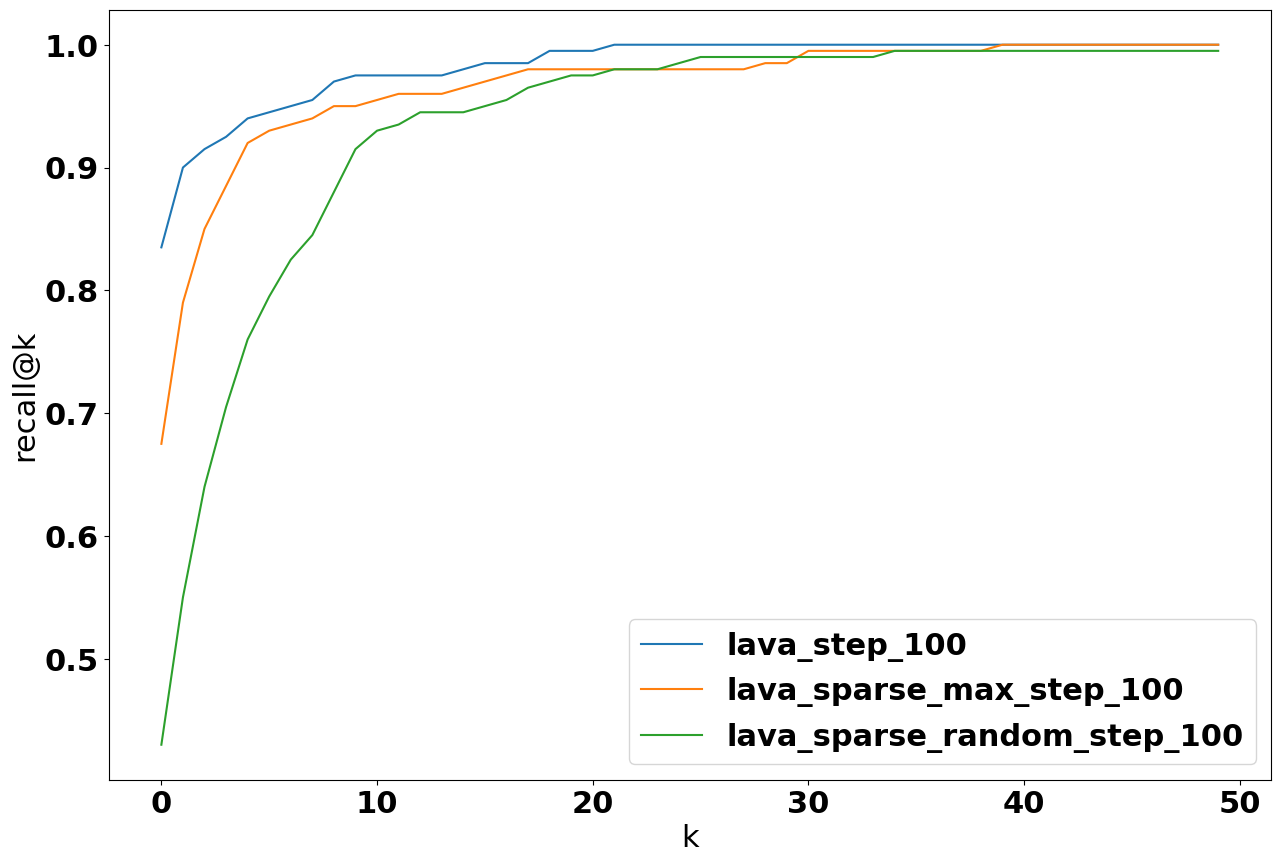

In [41]:
plt.figure(figsize=(15,10))
vals = 50
plt.plot(r_HRR_LOIHI[0:vals],label="lava_step_100")
plt.plot(r_HRR_LOIHI_sparse_100[0:vals],label="lava_sparse_max_step_100")
plt.plot(r_HRR_LOIHI_sparse_random_100[0:vals],label="lava_sparse_random_step_100")


plt.xlabel("k")
plt.ylabel("recall@k")

plt.legend()
plt.savefig("output/sparse.pdf")

### blcok-codes parameterization

#### Max parameterization

In [42]:
#HRR LOIHI
#main
# encode query and database to HD vectors

ks = [1, 3, 6, 9, 25, 50, 100]
timesteps = 2000
hrr_flag = True
recal_val_label = "only_positive_HRR"
only_positive = False

np.random.seed(np.sum(np.frombuffer(b'projection', dtype=np.uint8)))
#A = np.random.random((params["sDims"],params["nDims"]))
#A = np.random.normal(0, 0.1, (params["sDims"],params["nDims"]))
if only_positive:
    A = np.random.randn(params["sDims"], params["nDims"])
    print(np.min(A))
    vecs = A +np.abs(np.min(A))
else:
    A = np.random.randn(params["sDims"], params["nDims"])
#A = orth(A.T).T
# load matlab file
#A = A_mat["A"]

nBaseX = params["nX"]+1;
np.random.seed(np.sum(np.frombuffer(b'poseX', dtype=np.uint8)))
#X = 1-2*(np.random.random((nBaseX, params["nDims"]))>0.5);
X =  generate((nBaseX, params["nDims"]),only_positive=only_positive)
#X = X_mat["X"]

nBaseY = params["nY"]+1;
np.random.seed(np.sum(np.frombuffer(b'poseY', dtype=np.uint8)))
#Y = 1-2*(np.random.random((nBaseY, params["nDims"]))>0.5);
Y = generate((nBaseY, params["nDims"]),only_positive=only_positive)
#Y = Y_mat["Y"]
D1 = encodeImagesHDC(Yval, params)
D2 = encodeImagesHDC(Yval2, params)
normalizer = Normalizer()
# D1_norm = normalizer.fit_transform(D1)
# D2_norm = normalizer.fit_transform(D2)


k_values = [2,5,8,10]
k_results = []
for k_val_percentage in k_values:
    k_val = k_val_percentage * params["nDims"] //100
    print(k_val)

    # sparsify
    D1_sparse = normalizer.fit_transform(sparsify_all(D1,k_val))
    D2_sparse = normalizer.fit_transform(sparsify_all(D2,k_val))

    # send sign with datasetvectors
    ks=0

    maxK = 100
    nQ = len(D2_sparse)


    print(maxK,nQ)

    ids = np.zeros((maxK,nQ))
    # Iterate through all vectors in queries
    for index, vector in enumerate(tqdm(D2_sparse)):
        #print("data point",index)
        query_sign_vec = np.tile(np.sign(vector), (len(D1_sparse),1))
        # Let the snn produce a index
        #predictedIndexesPerK = bestDotMatch(np.multiply(D1_norm,query_sign_vec),np.abs(vector),ks)
        predictedIndexesPerK = findMatch(np.multiply(D1_sparse,query_sign_vec),np.abs(vector), timesteps, ks)
        ids[:,index] = predictedIndexesPerK
        # calculate recall values
    r_HRR_LOIHI_sparse =getRecallAtKVector(ids,g_truth["GT"])
    k_results.append(r_HRR_LOIHI_sparse)
    print(r_HRR_LOIHI_sparse)

/tmp/ipykernel_1573154/182283052.py:131: RuntimeWarning: invalid value encountered in double_scalars
  w = d2/(d1+d2);


81
100 200


100%|██████████| 200/200 [00:00<00:00, 615.59it/s]


[0.325 0.44  0.515 0.585 0.655 0.68  0.715 0.745 0.77  0.795 0.81  0.825
 0.845 0.855 0.865 0.88  0.885 0.885 0.9   0.915 0.92  0.93  0.93  0.935
 0.935 0.945 0.95  0.95  0.95  0.95  0.95  0.955 0.955 0.96  0.965 0.965
 0.965 0.97  0.97  0.97  0.97  0.97  0.975 0.975 0.975 0.975 0.975 0.975
 0.975 0.98  0.98  0.98  0.985 0.985 0.985 0.985 0.99  0.995 0.995 1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.   ]
204
100 200


100%|██████████| 200/200 [00:00<00:00, 611.02it/s]


[0.31  0.445 0.51  0.59  0.64  0.68  0.715 0.75  0.775 0.795 0.815 0.825
 0.835 0.85  0.86  0.875 0.885 0.895 0.91  0.915 0.92  0.925 0.93  0.93
 0.935 0.94  0.94  0.945 0.945 0.945 0.95  0.95  0.97  0.97  0.97  0.97
 0.97  0.975 0.975 0.975 0.975 0.975 0.975 0.975 0.975 0.975 0.975 0.975
 0.98  0.98  0.98  0.98  0.98  0.985 0.985 0.99  0.995 0.995 1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.   ]
327
100 200


100%|██████████| 200/200 [00:00<00:00, 616.78it/s]


[0.3   0.445 0.515 0.58  0.63  0.68  0.715 0.745 0.77  0.785 0.815 0.83
 0.835 0.855 0.86  0.865 0.88  0.89  0.895 0.905 0.915 0.925 0.93  0.93
 0.94  0.945 0.945 0.945 0.945 0.945 0.955 0.96  0.965 0.97  0.97  0.97
 0.975 0.975 0.975 0.975 0.975 0.975 0.975 0.975 0.975 0.975 0.975 0.98
 0.98  0.98  0.98  0.98  0.98  0.985 0.99  0.995 0.995 0.995 0.995 1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.   ]
409
100 200


100%|██████████| 200/200 [00:00<00:00, 614.08it/s]


[0.3   0.445 0.515 0.58  0.63  0.68  0.715 0.745 0.77  0.785 0.815 0.83
 0.835 0.855 0.86  0.865 0.88  0.89  0.895 0.905 0.915 0.925 0.93  0.93
 0.94  0.945 0.945 0.945 0.945 0.945 0.955 0.96  0.965 0.97  0.97  0.97
 0.975 0.975 0.975 0.975 0.975 0.975 0.975 0.975 0.975 0.975 0.975 0.98
 0.98  0.98  0.98  0.98  0.98  0.985 0.99  0.995 0.995 0.995 0.995 1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.   ]


In [43]:
!pwd

/homes/viduras/lava/My_tests/SLAM_Loihi


In [44]:
import pickle 


with open('max_first.pkl', 'wb') as handle:
    pickle.dump(k_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pkl', 'rb') as handle:
#     b = pickle.load(handle)

In [45]:
b[0][0:50]

NameError: name 'b' is not defined

In [ ]:
#HRR LOIHI
#main
# encode query and database to HD vectors

ks = [1, 3, 6, 9, 25, 50, 100]
timesteps = 2000
hrr_flag = True
recal_val_label = "only_positive_HRR"
only_positive = False

np.random.seed(np.sum(np.frombuffer(b'projection', dtype=np.uint8)))
#A = np.random.random((params["sDims"],params["nDims"]))
#A = np.random.normal(0, 0.1, (params["sDims"],params["nDims"]))
if only_positive:
    A = np.random.randn(params["sDims"], params["nDims"])
    print(np.min(A))
    vecs = A +np.abs(np.min(A))
else:
    A = np.random.randn(params["sDims"], params["nDims"])
#A = orth(A.T).T
# load matlab file
#A = A_mat["A"]

nBaseX = params["nX"]+1;
np.random.seed(np.sum(np.frombuffer(b'poseX', dtype=np.uint8)))
#X = 1-2*(np.random.random((nBaseX, params["nDims"]))>0.5);
X =  generate((nBaseX, params["nDims"]),only_positive=only_positive)
#X = X_mat["X"]

nBaseY = params["nY"]+1;
np.random.seed(np.sum(np.frombuffer(b'poseY', dtype=np.uint8)))
#Y = 1-2*(np.random.random((nBaseY, params["nDims"]))>0.5);
Y = generate((nBaseY, params["nDims"]),only_positive=only_positive)
#Y = Y_mat["Y"]
D1 = encodeImagesHDC(Yval, params)
D2 = encodeImagesHDC(Yval2, params)
normalizer = Normalizer()
# D1_norm = normalizer.fit_transform(D1)
# D2_norm = normalizer.fit_transform(D2)


k_values = [20,30,40,50]
k_results = []
for k_val_percentage in k_values:
    k_val = k_val_percentage * params["nDims"] //100
    print(k_val)

    # sparsify
    D1_sparse = normalizer.fit_transform(sparsify_all(D1,k_val))
    D2_sparse = normalizer.fit_transform(sparsify_all(D2,k_val))

    # send sign with datasetvectors
    ks=0

    maxK = 100
    nQ = len(D2_sparse)


    print(maxK,nQ)

    ids = np.zeros((maxK,nQ))
    # Iterate through all vectors in queries
    for index, vector in enumerate(tqdm(D2_sparse)):
        #print("data point",index)
        query_sign_vec = np.tile(np.sign(vector), (len(D1_sparse),1))
        # Let the snn produce a index
        #predictedIndexesPerK = bestDotMatch(np.multiply(D1_norm,query_sign_vec),np.abs(vector),ks)
        predictedIndexesPerK = findMatch(np.multiply(D1_sparse,query_sign_vec),np.abs(vector), timesteps, ks)
        ids[:,index] = predictedIndexesPerK
        # calculate recall values
    r_HRR_LOIHI_sparse =getRecallAtKVector(ids,g_truth["GT"])
    k_results.append(r_HRR_LOIHI_sparse)
    print(r_HRR_LOIHI_sparse)

In [ ]:
import pickle 


with open('max_second.pkl', 'wb') as handle:
    pickle.dump(k_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pkl', 'rb') as handle:
#     b = pickle.load(handle)

In [ ]:
import pickle 
with open('max_first.pkl', 'rb') as handle:
    b = pickle.load(handle)
    
with open('max_second.pkl', 'rb') as handle:
    c = pickle.load(handle)


plt.figure(figsize=(15,10))
k_values = [2,5,8,10]
vals = 50
for i in range(len(k_values)):
    print(i)
    plt.plot(b[i][0:vals],label=f"{k_values[i]}_max_sparse_block")
#plt.plot(HRR_LOIHI_sparse_ica[0:vals],label="lava_sparse_ica")
k_values = [20,30,40,50]
for i in range(len(k_values)):
    print(i)
    plt.plot(c[i][0:vals],label=f"{k_values[i]}_max_sparse_block")
#plt.plot(HRR_LOIHI_sparse_ica[0:vals],label="lava_sparse_ica")


plt.xlabel("k")
plt.ylabel("recall@k")

plt.legend()

plt.savefig("output/sparse_max_parameteraization.pdf")

#### Random Parameterization

### ICA

In [ ]:
#HRR LOIHI
#main
# encode query and database to HD vectors

ks = [1, 3, 6, 9, 25, 50, 100]
timesteps = 2000
hrr_flag = True
recal_val_label = "only_positive_HRR"
only_positive = False

np.random.seed(np.sum(np.frombuffer(b'projection', dtype=np.uint8)))
#A = np.random.random((params["sDims"],params["nDims"]))
#A = np.random.normal(0, 0.1, (params["sDims"],params["nDims"]))
if only_positive:
    A = np.random.randn(params["sDims"], params["nDims"])
    print(np.min(A))
    vecs = A +np.abs(np.min(A))
else:
    A = np.random.randn(params["sDims"], params["nDims"])
#A = orth(A.T).T
# load matlab file
#A = A_mat["A"]

nBaseX = params["nX"]+1;
np.random.seed(np.sum(np.frombuffer(b'poseX', dtype=np.uint8)))
#X = 1-2*(np.random.random((nBaseX, params["nDims"]))>0.5);
X =  generate((nBaseX, params["nDims"]),only_positive=only_positive)
#X = X_mat["X"]

nBaseY = params["nY"]+1;
np.random.seed(np.sum(np.frombuffer(b'poseY', dtype=np.uint8)))
#Y = 1-2*(np.random.random((nBaseY, params["nDims"]))>0.5);
Y = generate((nBaseY, params["nDims"]),only_positive=only_positive)
#Y = Y_mat["Y"]
D1 = encodeImagesHDC(Yval, params)
D2 = encodeImagesHDC(Yval2, params)
normalizer = Normalizer()
# D1_norm = normalizer.fit_transform(D1)
# D2_norm = normalizer.fit_transform(D2)


k_values = [2,5,8,10]
k_results_random = []
for k_val_percentage in k_values:
    k_val = k_val_percentage * params["nDims"] //100
    

    # sparsify
    D1_sparse = normalizer.fit_transform(sparsify_all_random(D1,k_val))
    D2_sparse = normalizer.fit_transform(sparsify_all_random(D2,k_val))

    # send sign with datasetvectors
    ks=0

    maxK = 100
    nQ = len(D2_sparse)


    print(maxK,nQ)

    ids = np.zeros((maxK,nQ))
    # Iterate through all vectors in queries
    for index, vector in enumerate(tqdm(D2_sparse)):
        #print("data point",index)
        query_sign_vec = np.tile(np.sign(vector), (len(D1_sparse),1))
        # Let the snn produce a index
        #predictedIndexesPerK = bestDotMatch(np.multiply(D1_norm,query_sign_vec),np.abs(vector),ks)
        predictedIndexesPerK = findMatch(np.multiply(D1_sparse,query_sign_vec),np.abs(vector), timesteps, ks)
        ids[:,index] = predictedIndexesPerK
        # calculate recall values
    r_HRR_LOIHI_sparse =getRecallAtKVector(ids,g_truth["GT"])
    k_results_random.append(r_HRR_LOIHI_sparse)
    print(r_HRR_LOIHI_sparse)

In [ ]:
import pickle 


with open('random_first.pkl', 'wb') as handle:
    pickle.dump(k_results_random, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pkl', 'rb') as handle:
#     b = pickle.load(handle)

In [ ]:
#HRR LOIHI
#main
# encode query and database to HD vectors

ks = [1, 3, 6, 9, 25, 50, 100]
timesteps = 2000
hrr_flag = True
recal_val_label = "only_positive_HRR"
only_positive = False

np.random.seed(np.sum(np.frombuffer(b'projection', dtype=np.uint8)))
#A = np.random.random((params["sDims"],params["nDims"]))
#A = np.random.normal(0, 0.1, (params["sDims"],params["nDims"]))
if only_positive:
    A = np.random.randn(params["sDims"], params["nDims"])
    print(np.min(A))
    vecs = A +np.abs(np.min(A))
else:
    A = np.random.randn(params["sDims"], params["nDims"])
#A = orth(A.T).T
# load matlab file
#A = A_mat["A"]

nBaseX = params["nX"]+1;
np.random.seed(np.sum(np.frombuffer(b'poseX', dtype=np.uint8)))
#X = 1-2*(np.random.random((nBaseX, params["nDims"]))>0.5);
X =  generate((nBaseX, params["nDims"]),only_positive=only_positive)
#X = X_mat["X"]

nBaseY = params["nY"]+1;
np.random.seed(np.sum(np.frombuffer(b'poseY', dtype=np.uint8)))
#Y = 1-2*(np.random.random((nBaseY, params["nDims"]))>0.5);
Y = generate((nBaseY, params["nDims"]),only_positive=only_positive)
#Y = Y_mat["Y"]
D1 = encodeImagesHDC(Yval, params)
D2 = encodeImagesHDC(Yval2, params)
normalizer = Normalizer()
# D1_norm = normalizer.fit_transform(D1)
# D2_norm = normalizer.fit_transform(D2)


k_values = [20,30,40,50]
k_results_random = []
for k_val_percentage in k_values:
    k_val = k_val_percentage * params["nDims"] //100
    

    # sparsify
    D1_sparse = normalizer.fit_transform(sparsify_all_random(D1,k_val))
    D2_sparse = normalizer.fit_transform(sparsify_all_random(D2,k_val))

    # send sign with datasetvectors
    ks=0

    maxK = 100
    nQ = len(D2_sparse)


    print(maxK,nQ)

    ids = np.zeros((maxK,nQ))
    # Iterate through all vectors in queries
    for index, vector in enumerate(tqdm(D2_sparse)):
        #print("data point",index)
        query_sign_vec = np.tile(np.sign(vector), (len(D1_sparse),1))
        # Let the snn produce a index
        #predictedIndexesPerK = bestDotMatch(np.multiply(D1_norm,query_sign_vec),np.abs(vector),ks)
        predictedIndexesPerK = findMatch(np.multiply(D1_sparse,query_sign_vec),np.abs(vector), timesteps, ks)
        ids[:,index] = predictedIndexesPerK
        # calculate recall values
    r_HRR_LOIHI_sparse =getRecallAtKVector(ids,g_truth["GT"])
    k_results_random.append(r_HRR_LOIHI_sparse)
    print(r_HRR_LOIHI_sparse)

In [ ]:
import pickle 


with open('random_second.pkl', 'wb') as handle:
    pickle.dump(k_results_random, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import pickle 
with open('random_first.pkl', 'rb') as handle:
    b = pickle.load(handle)
    
with open('random_second.pkl', 'rb') as handle:
    c = pickle.load(handle)


plt.figure(figsize=(15,10))
k_values = [2,5,8,10]
vals = 50
for i in range(len(k_values)):
    print(i)
    plt.plot(b[i][0:vals],label=f"{k_values[i]}_random_sparse_block")
#plt.plot(HRR_LOIHI_sparse_ica[0:vals],label="lava_sparse_ica")
k_values = [20,30,40,50]
for i in range(len(k_values)):
    print(i)
    plt.plot(c[i][0:vals],label=f"{k_values[i]}_random_sparse_block")
#plt.plot(HRR_LOIHI_sparse_ica[0:vals],label="lava_sparse_ica")


plt.xlabel("k")
plt.ylabel("recall@k")

plt.legend()

plt.savefig("output/sparse_random_parameteraization.pdf")

In [ ]:
import pickle 
with open('max_first.pkl', 'rb') as handle:
    a = pickle.load(handle)
    
with open('max_second.pkl', 'rb') as handle:
    b = pickle.load(handle)
    
with open('random_first.pkl', 'rb') as handle:
    c = pickle.load(handle)
    
with open('random_second.pkl', 'rb') as handle:
    d = pickle.load(handle)


plt.figure(figsize=(15,10))
k_values = [2,5,8,10]
vals = 50
for i in range(len(k_values)):
    print(i)
    plt.plot(a[i][0:vals],label=f"{k_values[i]}_max_sparse_block")
#plt.plot(HRR_LOIHI_sparse_ica[0:vals],label="lava_sparse_ica")
k_values = [20,30,40,50]
for i in range(len(k_values)):
    print(i)
    plt.plot(b[i][0:vals],label=f"{k_values[i]}_max_sparse_block")
#plt.plot(HRR_LOIHI_sparse_ica[0:vals],label="lava_sparse_ica")

for i in range(len(k_values)):
    print(i)
    plt.plot(c[i][0:vals],label=f"{k_values[i]}_random_sparse_block")
#plt.plot(HRR_LOIHI_sparse_ica[0:vals],label="lava_sparse_ica")
k_values = [20,30,40,50]
for i in range(len(k_values)):
    print(i)
    plt.plot(d[i][0:vals],label=f"{k_values[i]}_random_sparse_block")
#plt.plot(HRR_LOIHI_sparse_ica[0:vals],label="lava_sparse_ica")


plt.xlabel("k")
plt.ylabel("recall@k")

plt.legend()

plt.savefig("output/sparse_max_random_parameteraization.pdf")

### ICA

In [ ]:
from sklearn.datasets import load_digits
from sklearn.decomposition import FastICA

In [ ]:
"""Dimension reduction module"""

import numpy as np
from sklearn.decomposition import PCA, FastICA, TruncatedSVD, NMF
import os

class DimensionReduction:
    """
    Implements PCA/ICA dimensionality reduction for a dataset. 
    Useful to limit the dimensionality for KNN algorithm to fit in Loihi.
    """
    def __init__(self, encodingMatrix=None, encodingFile=None, dataset=None):
        """
        Initialize the dimension reduction module by either passing an encoding matrix,
        a path to a file containing an encoding matrix, or a dataset from which to compute
        the encoding matrix. If the file path does not exist, it will be written with the 
        computed encoding matrix.
        
        :param ndarray encodingMatrix: Optional, a pre-computed encoding matrix
        :param ndarray encodingFile: Optional, a path to a pre-computed encoding matrix
        :param ndarray dataset: Optional, a dataset from which to computed the encoding matrix
        """ 
        if encodingMatrix is not None:
            self.encoding=encodingMatrix
        elif encodingFile is not None:
            if os.path.isfile(encodingFile):
                self.encoding = np.load(encodingFile)
            elif dataset is not None:
                self.encoding = self._computeEncoding(dataset)
                np.save(encodingFile, self.encoding)
            else:
                assert False, "An encoding matrix, file, or dataset must be used for initialization"
        elif dataset is not None:
            self.encoding = self._computeEncoding(dataset)
        else:
            assert False, "An encoding matrix, file, or dataset must be used for initialization"
            
    def reduce(self, data):
        """
        Applies the encoding to data and returns the result.
        
        :param ndarray data: The data to encode, one sample per row.
        
        :returns: The encoded data, one sample per row
        :rtype: ndarray
        """
        encodedData = np.dot(data, self.encoding.T)
        #if len(encodedData.shape)>1:
        #    encodedData /= np.expand_dims(np.linalg.norm(encodedData, axis=1), axis=1) + np.finfo(float).eps
        return encodedData
    
    def _centerData(self, csData):
        """
        Makes the data zero mean.
        """
        csData -= csData.mean(axis=1)[:, np.newaxis]
        return csData
    
    
    def _computePCA(self, csData, num_components):
        """
        Computes PCA on the data.
        """
        pca_encoder = PCA(num_components)

        pca_coefs = pca_encoder.fit_transform(csData)
        pca_comps = pca_encoder.components_
        pca_eigs = pca_encoder.explained_variance_

        return pca_coefs, pca_comps, pca_eigs
    
    
    def _computeICA(self, pca_coefs, num_components, which_pcs=None):
        """
        Computes ICA on the data.
        """
        if which_pcs is None:
            which_pcs = np.arange(num_components)

        fica_encoder = FastICA(num_components)   
        ica_coefs = fica_encoder.fit_transform(pca_coefs[:, which_pcs])
        ica_comps = fica_encoder.components_

        return ica_coefs, ica_comps
    
    
    def _computeEncoding(self, inputData, num_components=1000, numSamples=50000):
        """
        Create a new encoding matrix from the input data.
        """
        numInputSamples = inputData.shape[0]
        if numInputSamples>numSamples:
            print("More than {} samples, only using the first {}".format(numSamples, numSamples))
            csData = inputData[:numSamples,:] 
        else:
            print("Fewer than {} samples, using all {}".format(numSamples, numInputSamples))
            csData = inputData
        
        csData = self._centerData(csData)

        pca_coefs, pca_comps, pca_eigs = self._computePCA(csData, num_components)
        ica_coefs, ica_comps = self._computeICA(pca_coefs, num_components)
        
        ica_comps /= ica_comps.std(axis=0)
        return np.dot(ica_comps, pca_comps[:num_components,:])

In [ ]:
#ICA
#main
# encode query and database to HD vectors

transformer_ica = FastICA(n_components=1024,
         random_state=0,
         whiten='unit-variance')

ks = [1, 3, 6, 9, 25, 50, 100]
timesteps = 2000
hrr_flag = True
recal_val_label = "only_positive_HRR"
only_positive = False

np.random.seed(np.sum(np.frombuffer(b'projection', dtype=np.uint8)))
#A = np.random.random((params["sDims"],params["nDims"]))
#A = np.random.normal(0, 0.1, (params["sDims"],params["nDims"]))
if only_positive:
    A = np.random.randn(params["sDims"], params["nDims"])
    print(np.min(A))
    vecs = A +np.abs(np.min(A))
else:
    A = np.random.randn(params["sDims"], params["nDims"])
#A = orth(A.T).T
# load matlab file
#A = A_mat["A"]

nBaseX = params["nX"]+1;
np.random.seed(np.sum(np.frombuffer(b'poseX', dtype=np.uint8)))
#X = 1-2*(np.random.random((nBaseX, params["nDims"]))>0.5);
X =  generate((nBaseX, params["nDims"]),only_positive=only_positive)
#X = X_mat["X"]

nBaseY = params["nY"]+1;
np.random.seed(np.sum(np.frombuffer(b'poseY', dtype=np.uint8)))
#Y = 1-2*(np.random.random((nBaseY, params["nDims"]))>0.5);
Y = generate((nBaseY, params["nDims"]),only_positive=only_positive)
#Y = Y_mat["Y"]
D1 = encodeImagesHDC(Yval, params)
D2 = encodeImagesHDC(Yval2, params)


# sparsify
icaencoderD1 = DimensionReduction(dataset=D1)
D1_sparse = icaencoderD1.reduce(D1)
icaencoderD2 = DimensionReduction(dataset=D2)
D2_sparse = icaencoderD2.reduce(D2)

normalizer = Normalizer()
D1_norm = normalizer.fit_transform(D1_sparse)
D2_norm = normalizer.fit_transform(D2_sparse)

# send sign with datasetvectors
ks=0

maxK = 100
nQ = len(D2_norm)


print(maxK,nQ)

ids = np.zeros((maxK,nQ))
# Iterate through all vectors in queries
for index, vector in enumerate(tqdm(D2_norm)):
    #print("data point",index)
    query_sign_vec = np.tile(np.sign(vector), (len(D1_norm),1))
    # Let the snn produce a index
    #predictedIndexesPerK = bestDotMatch(np.multiply(D1_norm,query_sign_vec),np.abs(vector),ks)
    predictedIndexesPerK = findMatch(np.multiply(D1_norm,query_sign_vec),np.abs(vector), timesteps, ks)
    ids[:,index] = predictedIndexesPerK
    # calculate recall values
HRR_LOIHI_sparse_ica =getRecallAtKVector(ids,g_truth["GT"])
print(HRR_LOIHI_sparse_ica)

In [ ]:
plt.figure(figsize=(15,10))
vals = 50
plt.plot(r_bipolar[0:vals],label="Aggregated DELF Descriptor")
plt.plot(HRR_LOIHI_sparse_ica[0:vals],label="lava_sparse_ica")


plt.xlabel("k")
plt.ylabel("recall@k")

plt.legend()
#plt.savefig("output/sparse.pdf")

### Nordland1000

In [ ]:
hdc_nordland_1 = loadmat("HDC-DELF-data/descriptors/Nordland1000/spring/delf_hdc_4096_ortho_sigma_nx5ny7.mat")
hdc_nordland_2 = loadmat("HDC-DELF-data/descriptors/Nordland1000/winter/delf_hdc_4096_ortho_sigma_nx5ny7.mat")


In [ ]:
g_truth_nordland = loadmat("HDC-DELF-data/ground_truth/Nordland1000/spring--winter/gt.mat")

In [ ]:
g_truth_nordland

In [ ]:
#ICA
#main
# encode query and database to HD vectors

transformer_ica = FastICA(n_components=1024,
         random_state=0,
         whiten='unit-variance')

ks = [1, 3, 6, 9, 25, 50, 100]
timesteps = 2000
hrr_flag = True
recal_val_label = "only_positive_HRR"
only_positive = False

np.random.seed(np.sum(np.frombuffer(b'projection', dtype=np.uint8)))
#A = np.random.random((params["sDims"],params["nDims"]))
#A = np.random.normal(0, 0.1, (params["sDims"],params["nDims"]))
if only_positive:
    A = np.random.randn(params["sDims"], params["nDims"])
    print(np.min(A))
    vecs = A +np.abs(np.min(A))
else:
    A = np.random.randn(params["sDims"], params["nDims"])
#A = orth(A.T).T
# load matlab file
#A = A_mat["A"]

nBaseX = params["nX"]+1;
np.random.seed(np.sum(np.frombuffer(b'poseX', dtype=np.uint8)))
#X = 1-2*(np.random.random((nBaseX, params["nDims"]))>0.5);
X =  generate((nBaseX, params["nDims"]),only_positive=only_positive)
#X = X_mat["X"]

nBaseY = params["nY"]+1;
np.random.seed(np.sum(np.frombuffer(b'poseY', dtype=np.uint8)))
#Y = 1-2*(np.random.random((nBaseY, params["nDims"]))>0.5);
Y = generate((nBaseY, params["nDims"]),only_positive=only_positive)
#Y = Y_mat["Y"]
D1 =  hdc_nordland_1['Y']#encodeImagesHDC(Yval, params)
D2 = hdc_nordland_2['Y']#encodeImagesHDC(Yval2, params)


# sparsify
icaencoderD1 = DimensionReduction(dataset=D1)
D1_sparse = icaencoderD1.reduce(D1)
icaencoderD2 = DimensionReduction(dataset=D2)
D2_sparse = icaencoderD2.reduce(D2)

normalizer = Normalizer()
D1_norm = normalizer.fit_transform(D1_sparse)
D2_norm = normalizer.fit_transform(D2_sparse)

# send sign with datasetvectors
ks=0

maxK = 100
nQ = len(D2_norm)


print(maxK,nQ)

ids = np.zeros((maxK,nQ))
# Iterate through all vectors in queries
for index, vector in enumerate(tqdm(D2_norm)):
    #print("data point",index)
    query_sign_vec = np.tile(np.sign(vector), (len(D1_norm),1))
    # Let the snn produce a index
    #predictedIndexesPerK = bestDotMatch(np.multiply(D1_norm,query_sign_vec),np.abs(vector),ks)
    predictedIndexesPerK = findMatch(np.multiply(D1_norm,query_sign_vec),np.abs(vector), timesteps, ks)
    ids[:,index] = predictedIndexesPerK
    # calculate recall values
HRR_LOIHI_sparse_ica_nordland =getRecallAtKVector(ids,g_truth_nordland["GT"])
print(HRR_LOIHI_sparse_ica_nordland)

In [ ]:
hdc_nordland_1["Y"].shape